# FrEIAを用いたFlowの構築と学習

このチュートリアルでは，Invertible Neural Networks; INNを構築するためのフレームワークFrEIAを用いて，Flowを構築し，学習するためのサンプルを提供します．

## 1. 2D-toy DatasetにおけるFlowの構築と学習

まずは，2D-toy Datasetにどのようなデータが含まれているかを確認します．

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons

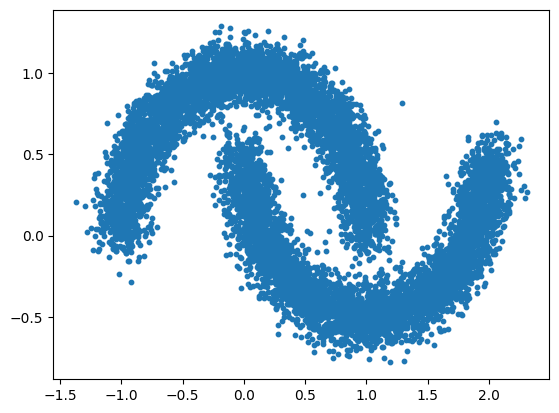

In [254]:
X, _ = make_moons(n_samples=10000, noise=0.1)
inputs = torch.from_numpy(X.astype(np.float32))
plt.scatter(inputs[:, 0], inputs[:, 1], s=10)
plt.show()

入力テンソルの形状は，(2,)です．次に簡単なFlowを構築します．

In [307]:
import torch
import torch.nn as nn

from FrEIA import framework as Ff
from FrEIA import modules as Fm

# subnetworkを定義
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 512),
        nn.ReLU(),
        nn.Linear(512, dims_out)
    )

# 今回は単純なAffine Couplingを順番に適用します．
# Sequential APIを用いてFlowを構築します．

input_dims = (2, )  # バッチサイズを除いた入力テンソルの形状

# SequenceINNを初期化
inn = Ff.SequenceINN(*input_dims)

# append()メソッドで追加
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc)

In [308]:
# 可逆なFlowを構築できているか確認
x = torch.rand(8, 2)
z, jac = inn(x)
x_inv, jac_inv = inn(z, rev=True)

assert torch.max(torch.abs(x - x_inv)) < 1e-5
assert torch.max(torch.abs(jac + jac_inv)) < 1e-5

それでは，Flowを学習させていきます．SequenceINNはtorch.nn.moduleを継承しているため，通常のNNの訓練と同じように学習させることができます．

In [309]:
dataloader = torch.utils.data.DataLoader(inputs, batch_size=32)

In [310]:
# 損失関数を定義
def likelihood(z: torch.Tensor, jac: torch.Tensor) -> torch.Tensor:
    """
    Args:
        z: 潜在変数z0, 多変量標準ガウス分布に従うと仮定, 形状は(B, D, ...), Dは潜在変数の次元．
        jac: 各変数変換における対数ヤコビ行列式の総和, 形状は(B, )
    Returns:
        対数尤度log(p(X))
    """
    # なぜこうなるのかについては，多変量ガウス分布の式を参照
    loss = 0.5*torch.sum(z**2, 1) - jac
    loss = loss.mean() / z.shape[1]
    return loss

それでは学習していきましょう．学習には長くて1時間ほどかかります．

In [311]:
import tqdm

# 学習するためのデバイスを設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルをGPU(CPU)に移す
inn.to(device)
optimizer = torch.optim.Adam(inn.parameters(), lr=1e-4)

for epoch in range(1000):
    for batch in tqdm.tqdm(dataloader):
        # 推論し，損失を計算
        x = batch.to(device)
        z, jac = inn(x)
        loss = likelihood(z, jac)

        # 勾配を初期化
        optimizer.zero_grad()

        # 勾配を計算
        loss.backward()

        # 重みを更新
        optimizer.step()

100%|██████████| 313/313 [00:04<00:00, 69.44it/s]


それでは学習したFlowを使って，潜在変数の分布からダブルムーン分布を生成できるかを試してみましょう．

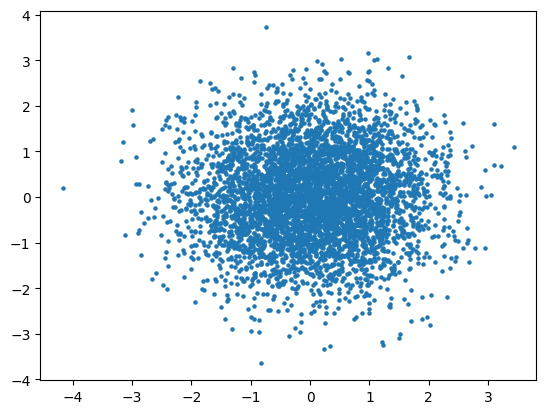

In [295]:
# 多変量標準ガウス分布からサンプリング
loc = torch.zeros(2)
cov_mat = torch.eye(2, 2)
test = torch.distributions.MultivariateNormal(loc=loc, covariance_matrix=cov_mat).sample(sample_shape=(5000,))

plt.scatter(test[:, 0], test[:, 1], s=5)
plt.show()

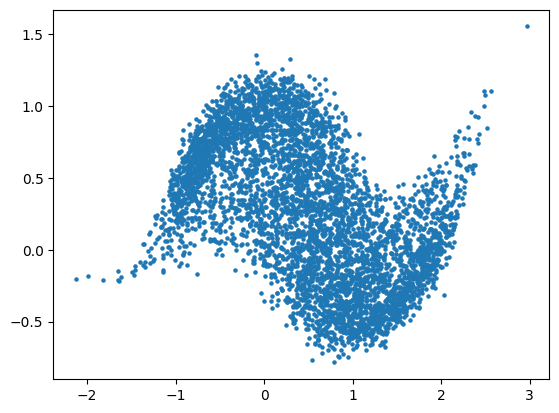

In [312]:
# 学習したFlowにより，ダブルムーン分布に逆変換
inn.to('cpu')

outputs, _ = inn(test, rev=True)
outputs = outputs.detach().numpy()
plt.scatter(outputs[:, 0], outputs[:, 1], s=5)
plt.show()

## 2. MNISTにおけるConditional Flowの構築

MNISTを用いて，各数字ラベル（1-hotベクトル）により条件付けられた分布を学習するFlowを構築してみましょう．この実装はFrEIAの開発者でもあるArdizzone氏により提案された[cINN](https://arxiv.org/abs/1907.02392)を参考にしています．気になった方はぜひ原論文も読んでみてください．